# Importing Necessary libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
import os 
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image
import shutil
from shutil import copyfile
from sklearn.model_selection import train_test_split
from tqdm import tqdm


# Loading Dataset

In [2]:
# shutil.rmtree('/kaggle/working/breast-histopathology-images')

In [3]:
try:
    os.mkdir('/kaggle/working/breast-histopathology-images')
    os.mkdir('/kaggle/working/breast-histopathology-images/training')
    os.mkdir('/kaggle/working/breast-histopathology-images/validation')
    os.mkdir('/kaggle/working/breast-histopathology-images/test')
    os.mkdir('/kaggle/working/breast-histopathology-images/training/negative')
    os.mkdir('/kaggle/working/breast-histopathology-images/training/positive')
    os.mkdir('/kaggle/working/breast-histopathology-images/validation/negative')
    os.mkdir('/kaggle/working/breast-histopathology-images/validation/positive')
    os.mkdir('/kaggle/working/breast-histopathology-images/test/negative')
    os.mkdir('/kaggle/working/breast-histopathology-images/test/positive')
except OSError:
    print('Error failed to make directory')

In [4]:
file_img_neg = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/*/0/*.png')
file_img_pos = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/*/1/*.png')

In [5]:
print(len(file_img_neg), len(file_img_pos))

198738 78786


In [6]:
train_img_neg, val_img_neg = train_test_split(file_img_neg[:12389], test_size=0.2, random_state=42)
train_img_pos, val_img_pos = train_test_split(file_img_pos[:12389], test_size=0.2, random_state=42)

In [7]:
for img_path in tqdm(train_img_neg):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/training/negative/{filename}')

for img_path in tqdm(train_img_pos):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/training/positive/{filename}')

for img_path in tqdm(val_img_neg):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/validation/negative/{filename}')

for img_path in tqdm(val_img_pos):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/validation/positive/{filename}')


100%|██████████| 2478/2478 [00:12<00:00, 196.53it/s]


In [8]:
test_neg = file_img_neg[12389:13389]
test_pos = file_img_pos[12389:13389]

for img_path in tqdm(test_neg):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/test/negative/{filename}')

for img_path in tqdm(test_pos):
    filename = os.path.basename(img_path)
    copyfile(img_path, f'/kaggle/working/breast-histopathology-images/test/positive/{filename}')

100%|██████████| 1000/1000 [00:05<00:00, 195.76it/s]


# Modeling

In [9]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc,classification_report

In [10]:
train_datagen = ImageDataGenerator(
#     preprocessing_function=stain_normalization,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
#     preprocessing_function=stain_normalization,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()


In [11]:
train_data_dir = '/kaggle/working/breast-histopathology-images/training'
valid_data_dir = '/kaggle/working/breast-histopathology-images/validation'
test_dir  = '/kaggle/working/breast-histopathology-images/test'

train_set = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(50, 50),
    batch_size=32,
    color_mode="rgb",
    shuffle=True,
    class_mode='binary'
)

val_set = val_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(50, 50),
    batch_size=32,
    color_mode="rgb",
    shuffle=True,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(50,50),
    batch_size=1,
    shuffle=False,
    class_mode='binary',
    color_mode='rgb'
)

Found 19822 images belonging to 2 classes.
Found 4956 images belonging to 2 classes.
Found 4956 images belonging to 2 classes.


## VGG16

In [12]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
vgg16 = tf.keras.applications.VGG16(input_shape=(50,50,3), 
                                    include_top=False, 
                                    weights="imagenet")
vgg16_model = Sequential()

vgg16_model.add(vgg16)
vgg16_model.add(GlobalMaxPooling2D())
vgg16_model.add(Dense(512, activation='relu'))
vgg16_model.add(Dropout(0.5))
vgg16_model.add(Dense(1, activation='sigmoid'))

58889256/58889256 [==============================] - 2s 0us/step


In [13]:
vgg16_model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,977,857
Trainable params: 14,977,857
Non-trainable params: 0
____________________________________________

In [15]:
vgg16_history = vgg16_model.fit(train_set,
                     validation_data=val_set,
                    epochs=20, verbose=1)

Epoch 1/20
620/620 [==============================] - 46s 54ms/step - loss: 0.5071 - accuracy: 0.7700 - val_loss: 0.4186 - val_accuracy: 0.8247
Epoch 2/20
620/620 [==============================] - 32s 51ms/step - loss: 0.3640 - accuracy: 0.8488 - val_loss: 0.3611 - val_accuracy: 0.8519
Epoch 3/20
620/620 [==============================] - 31s 51ms/step - loss: 0.3281 - accuracy: 0.8654 - val_loss: 0.3324 - val_accuracy: 0.8654
Epoch 4/20
620/620 [==============================] - 32s 51ms/step - loss: 0.2981 - accuracy: 0.8780 - val_loss: 0.2915 - val_accuracy: 0.8775
Epoch 5/20
620/620 [==============================] - 32s 52ms/step - loss: 0.2798 - accuracy: 0.8855 - val_loss: 0.2820 - val_accuracy: 0.8830
Epoch 6/20
620/620 [==============================] - 32s 52ms/step - loss: 0.2698 - accuracy: 0.8870 - val_loss: 0.3202 - val_accuracy: 0.8779
Epoch 7/20
620/620 [==============================] - 32s 52ms/step - loss: 0.2484 - accuracy: 0.9001 - val_loss: 0.2789 - val_accuracy:

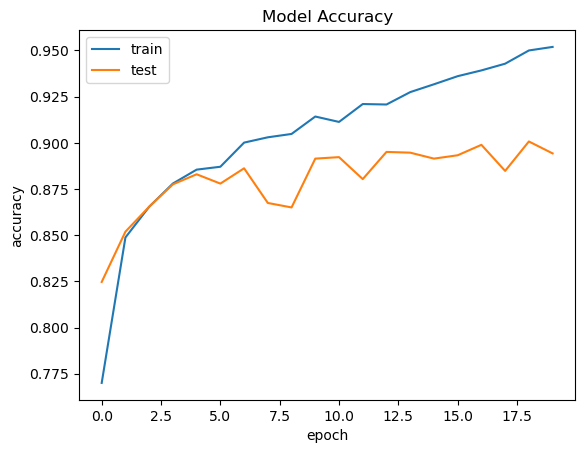

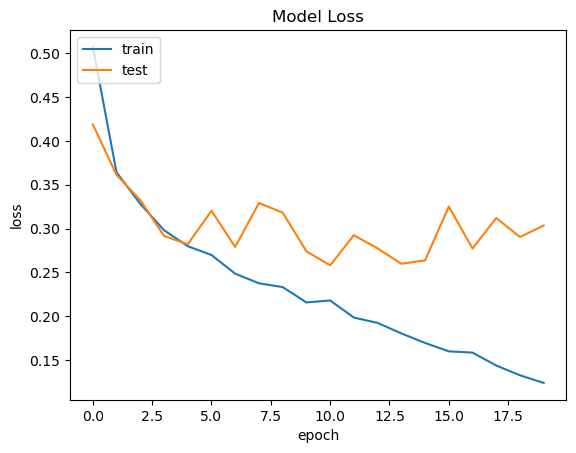

In [16]:
plt.plot(vgg16_history.history['accuracy'])
plt.plot(vgg16_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(vgg16_history.history['loss'])
plt.plot(vgg16_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
preds_vgg16 = vgg16_model.predict(
    test_generator,verbose= 1
)

4956/4956 [==============================] - 22s 4ms/step


In [18]:
image_ids = [name.split('/')[-1] for name in test_generator.filenames]
predictions = preds_vgg16.flatten()
data = {'id': image_ids, 'cancer':predictions} 
vgg_pred = pd.DataFrame(data)
vgg_pred['predict'] = vgg_pred['cancer'].apply(lambda x: 0 if x < 0.5 else 1)
vgg_pred['true'] = vgg_pred['id'].apply(lambda x: 0 if 'class0' in x else 1)
vgg_pred.head()

,id,cancer,predict,true
0,10274_idx5_x1001_y1251_class0.png,0.154100,0,0
1,10274_idx5_x1001_y2001_class0.png,0.004976,0,0
2,10274_idx5_x1001_y551_class0.png,0.005198,0,0
3,10274_idx5_x1001_y901_class0.png,0.838114,1,0
4,10274_idx5_x101_y1101_class0.png,0.004000,0,0


accuracy == 0.892


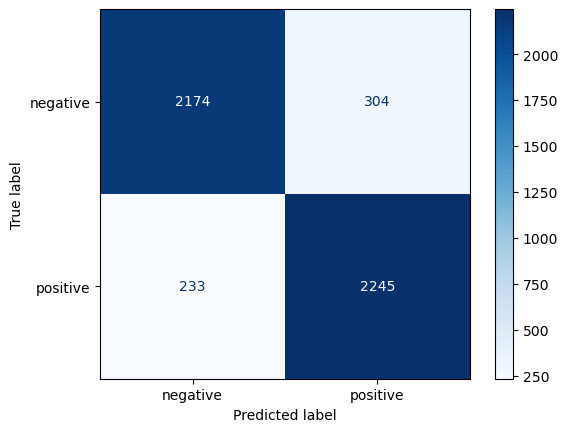

In [19]:
cm = confusion_matrix(vgg_pred['true'], vgg_pred['predict'])

# Step 4: Display the confusion matrix
labels = test_generator.class_indices.keys()  # Get class labels
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap='Blues')  # plot the confusion matrix
print(f'accuracy == {round(sum(vgg_pred.predict == vgg_pred.true)/len(vgg_pred),3)}')

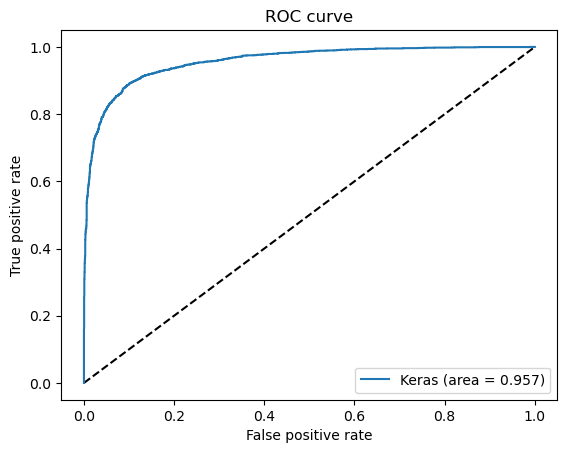

In [20]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(vgg_pred['true'], vgg_pred['cancer'])
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [21]:

target_names = ['No cancer', 'cancer']
print(classification_report(vgg_pred['true'], vgg_pred['predict'], target_names=target_names))

              precision    recall  f1-score   support

   No cancer       0.90      0.88      0.89      2478
      cancer       0.88      0.91      0.89      2478

    accuracy                           0.89      4956
   macro avg       0.89      0.89      0.89      4956
weighted avg       0.89      0.89      0.89      4956



## eff bvs

In [22]:
efficientnetv2s = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=(50,50,3),
)

82420632/82420632 [==============================] - 3s 0us/step


In [23]:
model_effv2s = Sequential()
model_effv2s.add((efficientnetv2s))
model_effv2s.add(GlobalAveragePooling2D())
model_effv2s.add(Dense(1, activation='sigmoid'))
model_effv2s.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 2, 2, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 20,332,641
Trainable params: 20,178,769
Non-trainable params: 153,872
_________________________________________________________________


In [24]:
opt = Adam(learning_rate=0.00001)
model_effv2s.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [25]:
history_effv2s = model_effv2s.fit(train_set,
                     validation_data=val_set,
                    epochs=20, verbose=1)

Epoch 1/20


2024-04-29 07:45:43.668710: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


620/620 [==============================] - 153s 114ms/step - loss: 0.5772 - accuracy: 0.6906 - val_loss: 0.4763 - val_accuracy: 0.7778
Epoch 2/20
620/620 [==============================] - 67s 108ms/step - loss: 0.4523 - accuracy: 0.7954 - val_loss: 0.4326 - val_accuracy: 0.8087
Epoch 3/20
620/620 [==============================] - 67s 109ms/step - loss: 0.4166 - accuracy: 0.8188 - val_loss: 0.4031 - val_accuracy: 0.8251
Epoch 4/20
620/620 [==============================] - 68s 109ms/step - loss: 0.4016 - accuracy: 0.8255 - val_loss: 0.3823 - val_accuracy: 0.8341
Epoch 5/20
620/620 [==============================] - 68s 110ms/step - loss: 0.3813 - accuracy: 0.8373 - val_loss: 0.3763 - val_accuracy: 0.8362
Epoch 6/20
620/620 [==============================] - 68s 109ms/step - loss: 0.3692 - accuracy: 0.8438 - val_loss: 0.3577 - val_accuracy: 0.8452
Epoch 7/20
620/620 [==============================] - 67s 109ms/step - loss: 0.3552 - accuracy: 0.8483 - val_loss: 0.3428 - val_accuracy: 0.

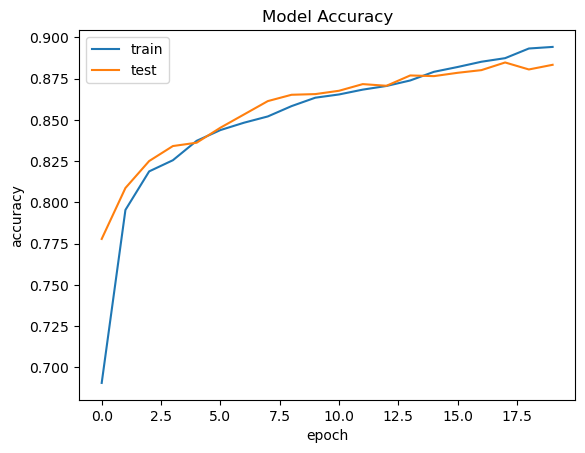

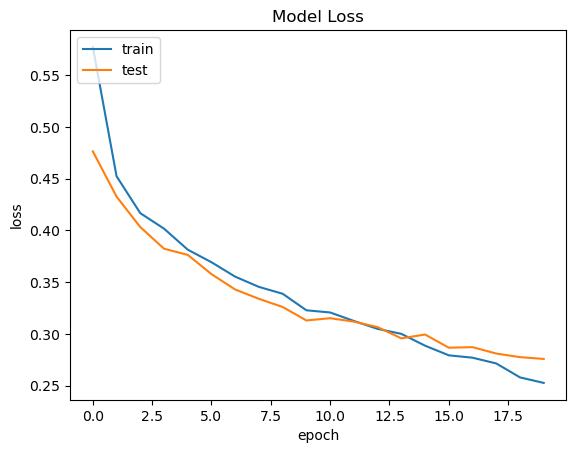

In [26]:
plt.plot(history_effv2s.history['accuracy'])
plt.plot(history_effv2s.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_effv2s.history['loss'])
plt.plot(history_effv2s.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [27]:
preds_effv2s = model_effv2s.predict(
    test_generator,verbose =1
)

4956/4956 [==============================] - 126s 25ms/step


In [28]:
image_ids = [name.split('/')[-1] for name in test_generator.filenames]
predictions = preds_effv2s.flatten()
data = {'id': image_ids, 'cancer':predictions} 
effv2s_pred = pd.DataFrame(data)
effv2s_pred['predict'] = [0 if i < 0.5 else 1 for i in effv2s_pred['cancer']]
effv2s_pred['true'] = [0 if 'class0' in i  else 1 for i in effv2s_pred['id']]
effv2s_pred.head()

,id,cancer,predict,true
0,10274_idx5_x1001_y1251_class0.png,0.032376,0,0
1,10274_idx5_x1001_y2001_class0.png,0.001426,0,0
2,10274_idx5_x1001_y551_class0.png,0.029339,0,0
3,10274_idx5_x1001_y901_class0.png,0.105990,0,0
4,10274_idx5_x101_y1101_class0.png,0.045362,0,0


accuracy == 0.874


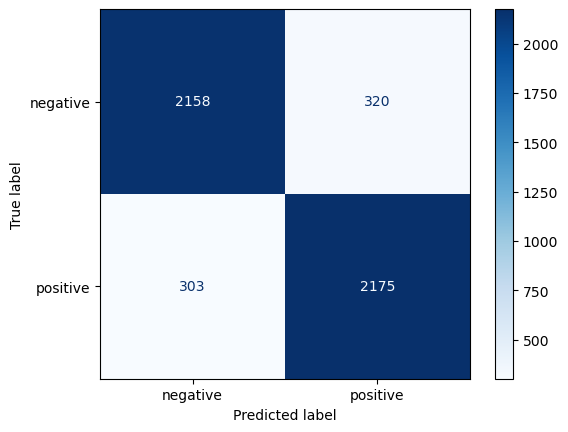

In [29]:
cm = confusion_matrix(effv2s_pred['true'], effv2s_pred['predict'])

# Step 4: Display the confusion matrix
labels = test_generator.class_indices.keys()  # Get class labels
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap='Blues')  # plot the confusion matrix
print(f'accuracy == {round(sum(effv2s_pred.predict == effv2s_pred.true)/len(effv2s_pred),3)}')

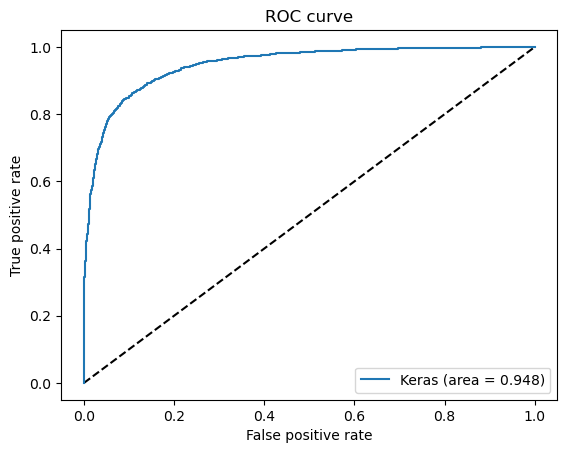

In [30]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(effv2s_pred['true'], effv2s_pred['cancer'])
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [31]:
target_names = ['No cancer', 'cancer']
print(classification_report(effv2s_pred['true'], effv2s_pred['predict'], target_names=target_names))

              precision    recall  f1-score   support

   No cancer       0.88      0.87      0.87      2478
      cancer       0.87      0.88      0.87      2478

    accuracy                           0.87      4956
   macro avg       0.87      0.87      0.87      4956
weighted avg       0.87      0.87      0.87      4956



## resnet50V2

In [32]:
resnet50 = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(50,50,3),
)

94668760/94668760 [==============================] - 3s 0us/step


In [33]:
model_resnet50 = Sequential()
model_resnet50.add(resnet50)
model_resnet50.add(GlobalMaxPooling2D())
model_resnet50.add(Dense(384, activation='relu'))
model_resnet50.add(Dense(1, activation='sigmoid'))
model_resnet50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_3 (Dense)             (None, 384)               786816    
                                                                 
 dense_4 (Dense)             (None, 1)                 385       
                                                                 
Total params: 24,352,001
Trainable params: 24,306,561
Non-trainable params: 45,440
_________________________________________________________________


In [34]:

model_resnet50.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.00001),
              metrics=['accuracy'])

In [35]:
history_resnet50 = model_resnet50.fit(train_set,
                     validation_data=val_set,
                    epochs=20, verbose=1)

Epoch 1/20
620/620 [==============================] - 73s 69ms/step - loss: 0.6596 - accuracy: 0.6916 - val_loss: 0.5976 - val_accuracy: 0.7448
Epoch 2/20
620/620 [==============================] - 39s 62ms/step - loss: 0.5451 - accuracy: 0.7553 - val_loss: 0.5404 - val_accuracy: 0.7536
Epoch 3/20
620/620 [==============================] - 38s 61ms/step - loss: 0.5112 - accuracy: 0.7700 - val_loss: 0.5004 - val_accuracy: 0.7859
Epoch 4/20
620/620 [==============================] - 38s 61ms/step - loss: 0.4894 - accuracy: 0.7770 - val_loss: 0.4719 - val_accuracy: 0.7908
Epoch 5/20
620/620 [==============================] - 38s 61ms/step - loss: 0.4610 - accuracy: 0.7927 - val_loss: 0.4592 - val_accuracy: 0.7984
Epoch 6/20
620/620 [==============================] - 38s 61ms/step - loss: 0.4420 - accuracy: 0.8017 - val_loss: 0.4473 - val_accuracy: 0.8089
Epoch 7/20
620/620 [==============================] - 39s 62ms/step - loss: 0.4280 - accuracy: 0.8117 - val_loss: 0.4408 - val_accuracy:

In [36]:
preds_resnet50 = model_resnet50.predict(
    test_generator,verbose =1
)

4956/4956 [==============================] - 45s 9ms/step


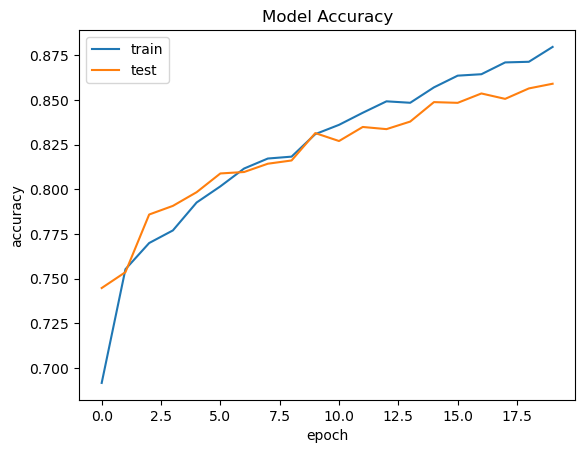

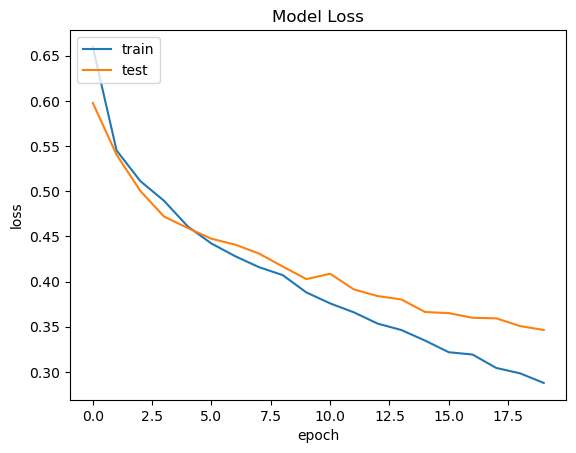

In [37]:
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
image_ids = [name.split('/')[-1] for name in test_generator.filenames]
predictions = preds_resnet50.flatten()
data = {'id': image_ids, 'cancer':predictions} 
resnet50_pred = pd.DataFrame(data)
resnet50_pred['predict'] = [0 if i < 0.5 else 1 for i in resnet50_pred['cancer']]
resnet50_pred['true'] = [0 if 'class0' in i  else 1 for i in resnet50_pred['id']]
resnet50_pred.head()

,id,cancer,predict,true
0,10274_idx5_x1001_y1251_class0.png,0.016519,0,0
1,10274_idx5_x1001_y2001_class0.png,0.002119,0,0
2,10274_idx5_x1001_y551_class0.png,0.059971,0,0
3,10274_idx5_x1001_y901_class0.png,0.317757,0,0
4,10274_idx5_x101_y1101_class0.png,0.386315,0,0


accuracy == 0.849


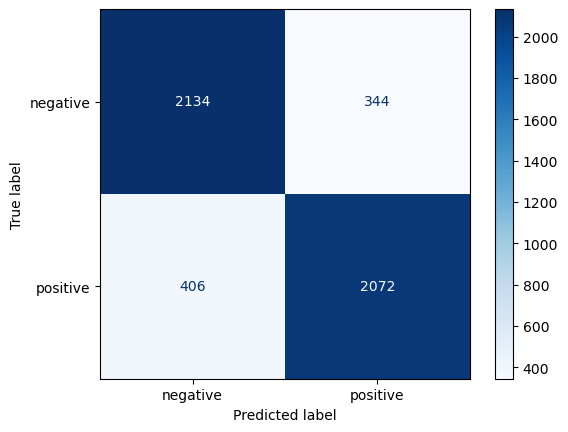

In [39]:
cm = confusion_matrix(resnet50_pred['true'], resnet50_pred['predict'])

# Step 4: Display the confusion matrix
labels = test_generator.class_indices.keys()  # Get class labels
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap='Blues')  # plot the confusion matrix
print(f'accuracy == {round(sum(resnet50_pred.predict == resnet50_pred.true)/len(resnet50_pred),3)}')

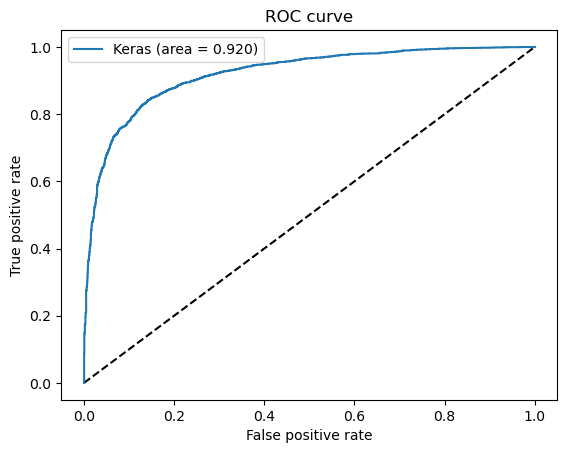

In [40]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(resnet50_pred['true'], resnet50_pred['cancer'])
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [41]:
target_names = ['No cancer', 'cancer']
print(classification_report(resnet50_pred['true'], resnet50_pred['predict'], target_names=target_names))

              precision    recall  f1-score   support

   No cancer       0.84      0.86      0.85      2478
      cancer       0.86      0.84      0.85      2478

    accuracy                           0.85      4956
   macro avg       0.85      0.85      0.85      4956
weighted avg       0.85      0.85      0.85      4956

